# Variational Auto-encoder

## Description of the algorithm

Let us consider a dataset $X = \{x^{(i)}\}_{i=1}^N$ consisting of N i.i.d. samples. We assume that the data are generated from parametric family of distributions $p_{\theta^*}(x)$ and we introduce the generative model $p_{\theta^*}(x, z) = p_{\theta^*}(x|z)p_{\theta^*}(z)$ where $z$ is an unobserved continuous random variable. The true parameters $\theta^*$ and the values of the latent variables $z^{(i)}$ are unknown to us. 

It is worth noting that we are interested in a general algorithm that works efficiently in the case of:
* intractability of the marginal likelihood $p_{\theta}(x) = \int p_{\theta}(x|z)p_{\theta}(z)dz$ and the true posterior density $p_{\theta}(z|x) = \dfrac{p_{\theta}(x|z)p_{\theta}(z)}{p_{\theta}(x)}$;
* a large dataset when we can make parameter updates in stochastic gradient decent using only small minibatches or even single datapoints.

Our purpose is to solve the following three problems:
* efficient approximate ML or MAP estimation for the parameters $\theta$; 
* efficient approximate posterior inference of the latent variable $p_{\theta}(z|x)$; 
* efficient approximate marginal marginal inference of the variable x $p_{\theta}(x)$. 

The algorithm which solves the above problems was proposed by D. Kingma and Prof. Dr. M. Welling in the paper [Auto-Encoding Variational Bayes](http://arxiv.org/abs/1312.6114). At first authors introduce a recognition model $q_{\varphi}(z|x)$: an approximation to the intractable true posterior $p_{\theta}(z|x)$. After Kingma et al. introduce a method for learning the recognition model parameters $\varphi$ jointly with the generative model parameters $\theta$. 

The key idea is to use the variational lower bound of the marginal likelihood 
$\sum\limits_{i=1}^N\ln p_{\theta}(x^{(i)})$:
$$
\ln p_{\theta}(x^{(i)}) = D_{KL}(q_{\varphi}(z|x^{(i)})||p_{\theta}(z|x^{(i)})) + L(\theta, \varphi; x^{(i)}) \quad \Rightarrow 
$$
$$
\Rightarrow \quad \ln p_{\theta}(x^{(i)}) \geqslant L(\theta, \varphi; x^{(i)}) = \mathbf{E}_{q_{\varphi}(z|x)}\left(-\ln q_{\varphi}(z|x) + \ln p_{\theta}(x, z)\right) = -D_{KL}(q_{\varphi}(z|x^{(i)})||p_{\theta}(z)) + \mathbf{E}_{q_{\varphi}(z|x^{(i)})}(\ln p_{\theta}(x^{(i)}|z))
$$

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(fan_in, fan_out, constant=1): 
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [4]:
class VariationalAutoencoder(object):
    def __init__(self, n_input, n_z, network_architecture, 
                 learning_rate=0.001):
        self.n_input = n_input
        self.n_z = n_z
        self.network_architecture = network_architecture
        self.learning_rate = learning_rate
        
        self.x = tf.placeholder(tf.float32, [None, n_input])
        
        self._create_network()
        
        self._create_loss_optimizer()
        
        init = tf.initialize_all_variables()
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _create_network(self):
        self.weights = self._initialize_weights(**self.network_architecture)
        
        encoder_layer1 = tf.nn.softplus(tf.add(tf.matmul(self.x, self.weights['encoder']['h1']),
                                               self.weights['encoder']['b1']))
        encoder_layer2 = tf.nn.softplus(tf.add(tf.matmul(encoder_layer1, self.weights['encoder']['h2']), 
                                               self.weights['encoder']['b2']))
        self.z_mean = tf.add(tf.matmul(encoder_layer2, self.weights['encoder']['out_mean']), 
                             self.weights['encoder']['out_mean_b'])
        self.z_log_sigma_sq = tf.add(tf.matmul(encoder_layer2, self.weights['encoder']['out_log_sigma_sq']), 
                                     self.weights['encoder']['out_log_sigma_sq_b'])
        epsilon = tf.random_normal((tf.shape(self.x)[0], self.n_z), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.z_mean, tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), epsilon))
        
        decoder_layer1 = tf.nn.softplus(tf.add(tf.matmul(self.z, self.weights['decoder']['h1']),
                                               self.weights['decoder']['b1']))
        decoder_layer2 = tf.nn.softplus(tf.add(tf.matmul(decoder_layer1, self.weights['decoder']['h2']), 
                                               self.weights['decoder']['b2']))
        self.x_reconstruction = tf.sigmoid(tf.add(tf.matmul(decoder_layer2, self.weights['decoder']['out_mean']),
                                                  self.weights['decoder']['out_mean_b']))
        
    def _initialize_weights(self, n_hidden_encoder_1, n_hidden_encoder_2, 
                           n_hidden_decoder_1, n_hidden_decoder_2):
        weights = dict()
        weights['encoder'] = {
            'h1': tf.Variable(xavier_init(self.n_input, n_hidden_encoder_1)), 
            'h2': tf.Variable(xavier_init(n_hidden_encoder_1, n_hidden_encoder_2)), 
            'out_mean': tf.Variable(xavier_init(n_hidden_encoder_2, self.n_z)),
            'out_log_sigma_sq': tf.Variable(xavier_init(n_hidden_encoder_2, self.n_z)),
            
            'b1': tf.Variable(tf.zeros([n_hidden_encoder_1], dtype=tf.float32)), 
            'b2': tf.Variable(tf.zeros([n_hidden_encoder_2], dtype=tf.float32)), 
            'out_mean_b': tf.Variable(tf.zeros([self.n_z], dtype=tf.float32)),
            'out_log_sigma_sq_b': tf.Variable(tf.zeros([self.n_z], dtype=tf.float32))
        }
        weights['decoder'] = {
            'h1': tf.Variable(xavier_init(self.n_z, n_hidden_decoder_1)), 
            'h2': tf.Variable(xavier_init(n_hidden_decoder_1, n_hidden_decoder_2)), 
            'out_mean': tf.Variable(xavier_init(n_hidden_encoder_2, self.n_input)),
            
            'b1': tf.Variable(tf.zeros([n_hidden_decoder_1], dtype=tf.float32)), 
            'b2': tf.Variable(tf.zeros([n_hidden_decoder_2], dtype=tf.float32)), 
            'out_mean_b': tf.Variable(tf.zeros([self.n_input], dtype=tf.float32))
        }
        return weights
    
    def _create_loss_optimizer(self):
        decoder_loss = 0.5 * tf.reduce_sum(tf.square(tf.sub(self.x_reconstruction, self.x)))
        encoder_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                            - tf.square(self.z_mean) 
                                            - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(decoder_loss + encoder_loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z=None):
        if z is None:
            z = np.random.normal(size=self.n_z)
        return self.sess.run(self.x_reconstruction, feed_dict={self.z: z})
    
    def reconstruct(self, X):
        return self.sess.run(self.x_reconstruction, feed_dict={self.x: X})
    
    def score(self, X):
        return self.sess.run(self.cost, feed_dict={self.x: X})

In [5]:
n_samples = mnist.train.num_examples
n_input = 784
n_z = 20
batch_size = 100
learning_rate = 0.001

network_architecture = {
    'n_hidden_encoder_1': 500,
    'n_hidden_encoder_2': 500,
    'n_hidden_decoder_1': 500,
    'n_hidden_decoder_2': 500
}

In [6]:
def train(data, n_samples, n_input, n_z, 
          batch_size, learning_rate, network_architecture, 
         training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(n_input, n_z, 
                                 network_architecture, learning_rate)
    for epoch in xrange(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        for i in xrange(total_batch):
            batch_xs, _ = data.train.next_batch(batch_size)
            cost = vae.partial_fit(batch_xs)
            avg_cost += cost / n_samples * batch_size
            
        if epoch % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), \
                  "cost =", "{:.9f}".format(avg_cost)
    return vae

In [7]:
vae = train(mnist, n_samples, n_input, n_z, 
            batch_size, learning_rate, 
            network_architecture, training_epochs=75)

Epoch: 0001 cost = 1524.858572110
Epoch: 0006 cost = 399.764994396
Epoch: 0011 cost = 338.895880626
Epoch: 0016 cost = 311.186203669
Epoch: 0021 cost = 293.587303495
Epoch: 0026 cost = 281.870884316
Epoch: 0031 cost = 272.170399336
Epoch: 0036 cost = 265.640589572
Epoch: 0041 cost = 259.219077287
Epoch: 0046 cost = 254.087861800
Epoch: 0051 cost = 250.029959550
Epoch: 0056 cost = 246.137447316
Epoch: 0061 cost = 242.773156960
Epoch: 0066 cost = 239.583189947
Epoch: 0071 cost = 236.713028620


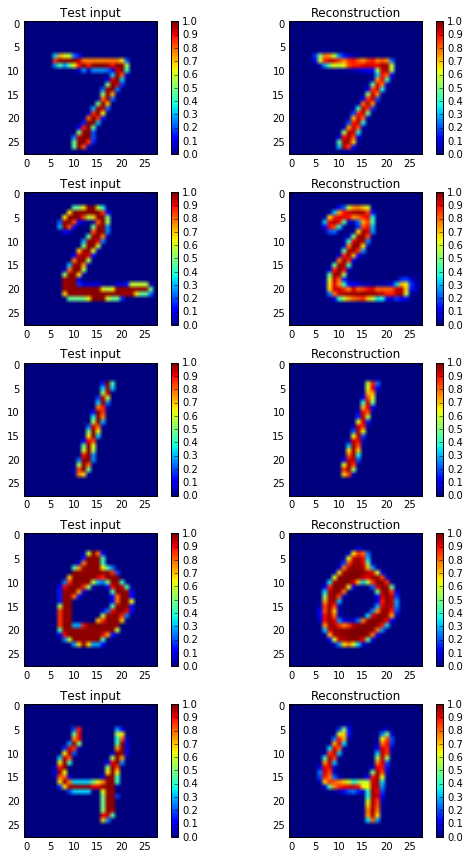

In [8]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [9]:
n_z = 2
vae_2d = train(mnist, n_samples, n_input, n_z, 
               batch_size, learning_rate, 
               network_architecture, training_epochs=75)

Epoch: 0001 cost = 2147.780113636
Epoch: 0006 cost = 1618.724472878
Epoch: 0011 cost = 1532.431992853
Epoch: 0016 cost = 1487.748814364
Epoch: 0021 cost = 1456.177727051
Epoch: 0026 cost = 1433.276054466
Epoch: 0031 cost = 1415.035269664
Epoch: 0036 cost = 1399.018770641
Epoch: 0041 cost = 1386.447326660
Epoch: 0046 cost = 1374.211488814
Epoch: 0051 cost = 1365.756500577
Epoch: 0056 cost = 1357.359654430
Epoch: 0061 cost = 1349.450907981
Epoch: 0066 cost = 1342.930579723
Epoch: 0071 cost = 1337.201903631


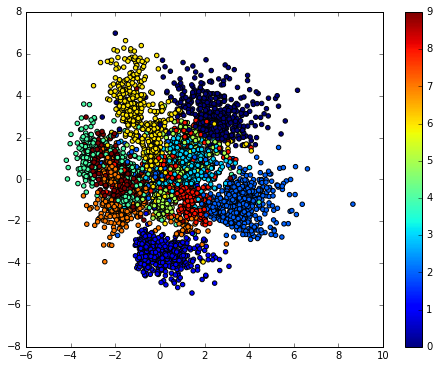

In [10]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_sample = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_sample[:, 0], z_sample[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()

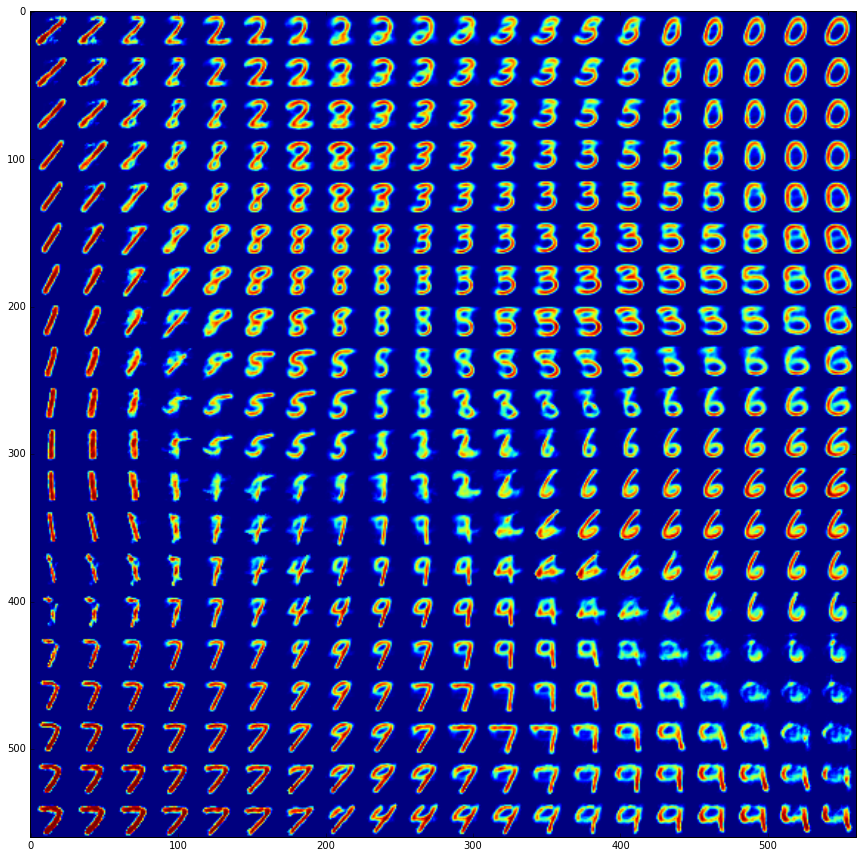

In [12]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, xi in enumerate(x_values):
    for j, yi in enumerate(y_values):
        z = np.array([[xi, yi]])
        x_reconstruction = vae_2d.generate(z)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_reconstruction[0].reshape(28, 28)

plt.figure(figsize=(16, 12))
plt.imshow(canvas, origin="upper")
plt.tight_layout()